In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib


Load Dataset


In [4]:
data = pd.read_csv("../data/Telco-Customer-Churn.csv")

print("Dataset Info:")
print(data.info())

print("\nMissing Values:")
print(data.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

Data Cleaning


In [8]:
# Convert TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill missing values safely (no inplace)
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())


EDA – Churn Distribution

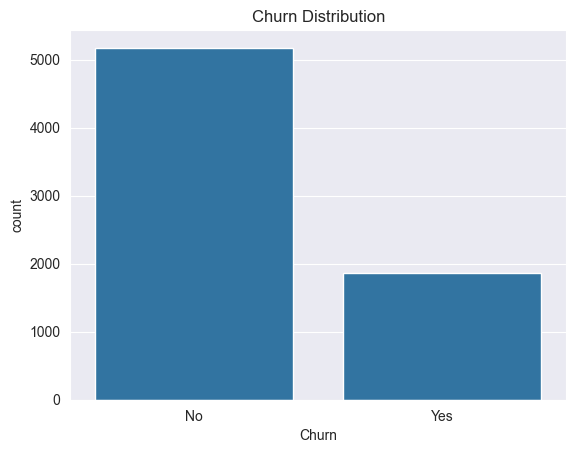

In [9]:
sns.countplot(x='Churn', data=data)
plt.title("Churn Distribution")
plt.show()


EDA – Tenure vs Churn

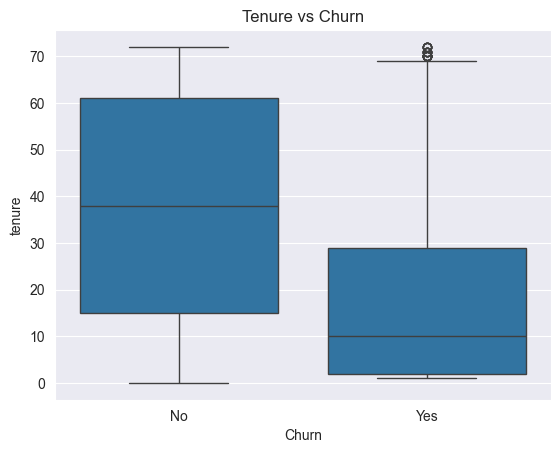

In [10]:
sns.boxplot(x='Churn', y='tenure', data=data)
plt.title("Tenure vs Churn")
plt.show()


EDA – Correlation Heatmap

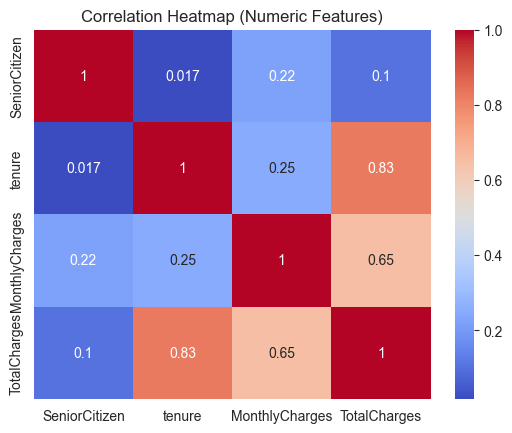

In [11]:
# Only numeric columns for correlation
numeric_data = data.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


Data Preprocessing

In [12]:
# Encode target
le = LabelEncoder()
data['Churn'] = le.fit_transform(data['Churn'])

# Encode categorical variables
categorical_cols = data.select_dtypes(include='object').columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Scale numerical features safely
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[num_cols] = scaler.fit_transform(data[num_cols])

# Split features & target
X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Decision Tree Model

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1036
           1       0.71      0.46      0.56       373

    accuracy                           0.81      1409
   macro avg       0.77      0.70      0.72      1409
weighted avg       0.80      0.81      0.79      1409



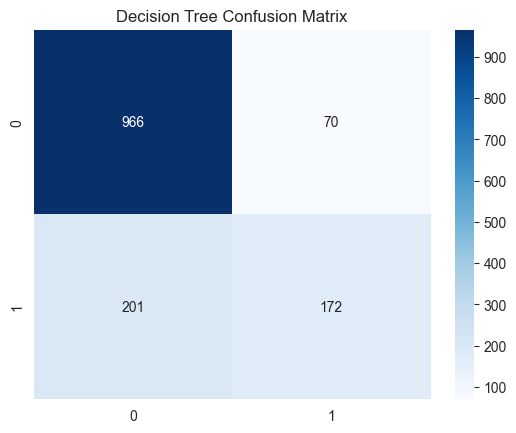

In [13]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()


Neural Network Model

In [14]:
nn = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = nn.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

y_pred_nn = (nn.predict(X_test) > 0.5).astype("int32")
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1036
           1       0.59      0.55      0.57       373

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



Neural Network Training Plots

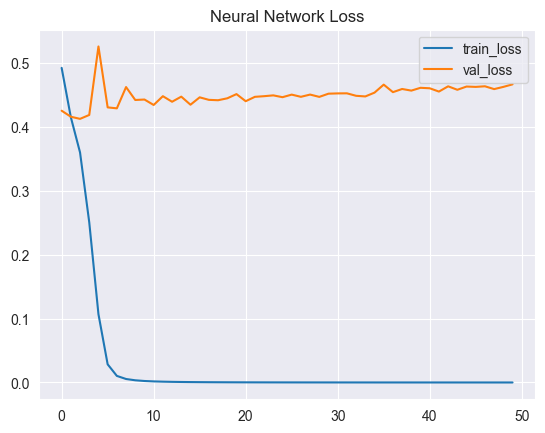

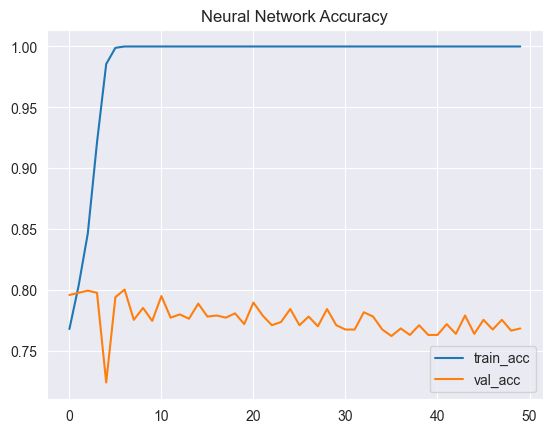

In [15]:
# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Neural Network Loss")
plt.legend()
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Neural Network Accuracy")
plt.legend()
plt.show()


Model Comparison (ROC-AUC)

In [16]:
roc_auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])
roc_auc_nn = roc_auc_score(y_test, nn.predict(X_test))

print(f"Decision Tree ROC-AUC: {roc_auc_dt:.3f}")
print(f"Neural Network ROC-AUC: {roc_auc_nn:.3f}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Decision Tree ROC-AUC: 0.851
Neural Network ROC-AUC: 0.807


Save Models

In [18]:
# Save Decision Tree
joblib.dump(dt, '../results/decision_tree_model.pkl')

# Save Neural Network in recommended Keras format
nn.save('../results/neural_network_model.keras')


User Input Prediction Function

In [23]:
nn_model = None  # initialize global variable

def predict_new_customer(customer_dict, model_type="nn"):
    global nn_model
    df = pd.DataFrame([customer_dict])

    # One-hot encode
    df = pd.get_dummies(df)

    # Align columns with training data
    df = df.reindex(columns=X_train.columns, fill_value=0)

    # Scale numerical features
    df[num_cols] = scaler.transform(df[num_cols])

    if model_type == "nn":
        if nn_model is None:
            nn_model = tf.keras.models.load_model('../results/neural_network_model.keras')
        pred = (nn_model.predict(df) > 0.5).astype("int32")[0][0]
    else:
        pred = dt.predict(df)[0]

    return "Churn:Yes" if pred == 1 else "Churn:No"


Prediction

In [24]:
customer_example = {
    'gender':'Female', 'SeniorCitizen':0, 'Partner':'Yes', 'Dependents':'No',
    'tenure':12, 'PhoneService':'Yes', 'MultipleLines':'No',
    'InternetService':'Fiber optic', 'OnlineSecurity':'No',
    'OnlineBackup':'Yes', 'DeviceProtection':'No',
    'TechSupport':'No', 'StreamingTV':'No', 'StreamingMovies':'No',
    'Contract':'Month-to-month', 'PaperlessBilling':'Yes', 'PaymentMethod':'Electronic check',
    'MonthlyCharges':70.35, 'TotalCharges':845.5
}

print("Prediction for new customer:", predict_new_customer(customer_example, model_type="nn"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Prediction for new customer: Churn:No
